In [1]:
%matplotlib inline
from ROOT import TFile, TTree
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from root_numpy import root2array
from collections import OrderedDict

In [8]:
filebase = '/Users/dayajun/LArLite/UserDev/LowEnergyExcess/output/'
#filebase += '70KV/112115_collabmtg/default_config/perfect_reco/'
#filebase = '/Users/davidkaleko/larlite/UserDev/LArLiteApp/LowEPlots/mac/output/70KV/'
filenames = OrderedDict([('nue','singleE_nue_selection_mc.root'),
                         ('numu','singleE_numu_selection_mc.root'),
                         ('nc','singleE_nc_selection_mc.root'),
                         ('cosmic','singleE_cosmic_selection_mc.root') ])#,
#                        ('lee','singleE_LEE_selection_mc.root')
#                        ])
treenames = { 'nue' : 'beamNuE',
             'cosmic' : 'cosmicShowers',
             'numu' : 'beamNuMu',
             'nc' : 'beamNC',
            'lee' : 'LEETree'}
labels = { 'nue' : 'Beam Intrinsic Nue',
         'cosmic' : 'Cosmic, in-time',
         'numu' : 'Beam Intrinsic Numu',
         'nc' : 'Beam Intrinsic NC', 
         'lee' : 'Scaled Low Energy Excess'}
colors = { 'nue' : '#269729', #kGreen-2
         'numu' : '#4B4EAC', #kBlue-5
          'nc' : '#6B70F5', #kBlue-9
          'cosmic' : '#D12C2C', #kRed-3
          'lee' : '#E65C00' #orangish
          }
binning = np.linspace(0.1,3,29)
#binning = np.linspace(0.1,3,15)
scaling_weights = { 'nue' : 6.6e20/(2.706e15*96000), #should be 99600, used 96000 for collab meeting
             'cosmic' : 211000/6.4/13100, #(211,000 ms total exposure)/(6.4ms * 13100 evts generated)
             'numu' : 6.6e20/(2.706e15*96000),
             'nc' : 6.6e20/(2.706e15*96000),
                  'lee' : 1}
#10cm from all sides
#fidvolcut = '_x_vtx > 10 and _x_vtx < 246.35 and _y_vtx > -106.5 and _y_vtx < 106.5 and _z_vtx > 10 and _z_vtx < 1026.8'
fidvolcut = '_dist_2wall > 20'
defaultcut = '_longestTrackLen < 100.'

In [9]:
dfs = OrderedDict()
for key, filename in filenames.iteritems():
    dfs.update( { key : pd.DataFrame( root2array( filebase + filename, treenames[key] ) ) } )

In [10]:
def gen_histos(myquery=''):
    nphistos = OrderedDict()

    for key, df in dfs.iteritems():
        if key == 'lee': continue
        mydf = df.query(myquery) if myquery else df
        if key == 'cosmic':
            myweights = np.ones(mydf['_e_nuReco'].shape[0])
        else:
            #NOTE: using ravel() seems to actually modify the dataframe itself
            #which causes weird behavior when this function is called repeatedly
            #so just cast the series as an array (as done below) instead.
            #I don't understand why ravel() modifies the DF.
            myweights = np.array(mydf['_weight'])#.ravel()
        myweights *= scaling_weights[key]
        nphistos.update( {key : np.histogram(mydf['_e_nuReco']/1000.,
                                     bins=binning,
                                     weights=myweights)} )
    return nphistos

In [11]:
def plot_fullstack(myhistos):
    fig = plt.figure(figsize=(10,6))
    plt.grid(True)
    lasthist = 0
    for key, (hist, bins) in myhistos.iteritems():
        if key == 'lee': continue
        plt.bar(bins[:-1],hist,
                width=bins[1]-bins[0],
                color=colors[key],
                bottom = lasthist,
                edgecolor = 'k',
                label='%s: %d Events'%(labels[key],sum(hist)))
        lasthist += hist
    
    plt.xlim([binning[0],binning[-1]])
    plt.ylim([0,600])
    plt.title('CCSingleE Stacked Backgrounds',fontsize=25)
    plt.ylabel('Events',fontsize=20)
    plt.xlabel('Reconstructed Neutrino Energy [GeV]',fontsize=20)
    plt.legend()

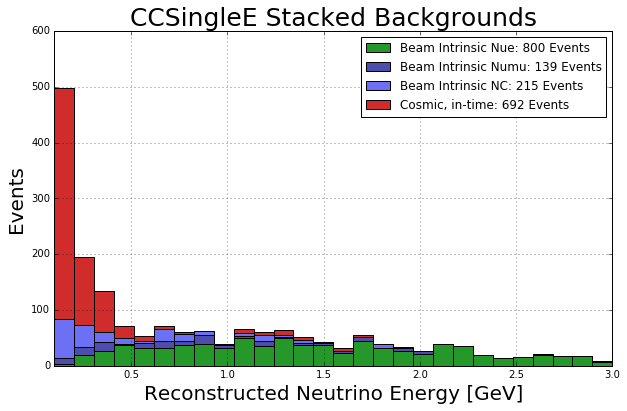

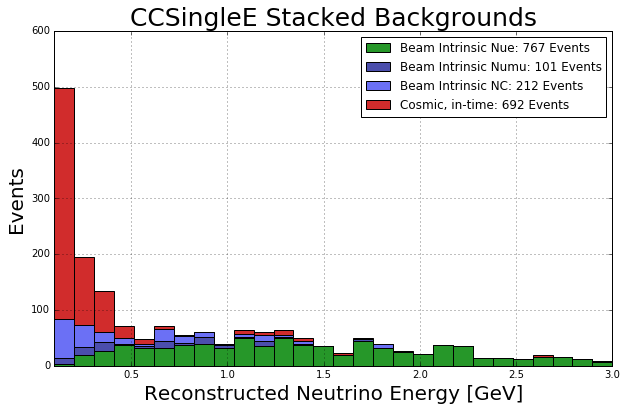

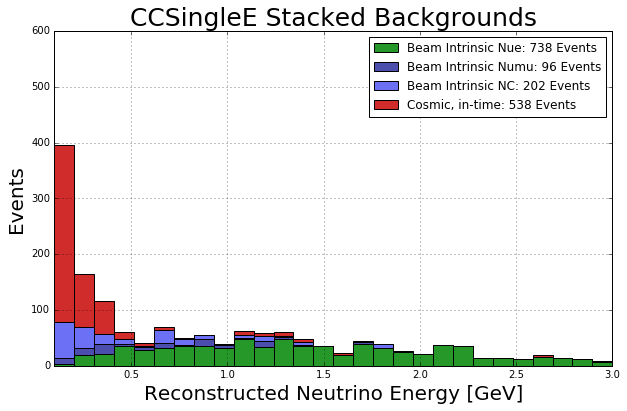

In [12]:
#nphistos = gen_histos('_is_fiducial==True and _longestTrackLen < 1')
plot_fullstack(gen_histos())
plot_fullstack(gen_histos(defaultcut))
plot_fullstack(gen_histos(defaultcut + ' and ' + fidvolcut))
#plot_fullstack(gen_histos())
#plot_fullstack(gen_histos(fidvolcut))

In [59]:
def plot_onehist(key,myhistos):
    fig = plt.figure(figsize=(10,6))
    plt.grid(True)
    hist, bins = myhistos[key]
    plt.bar(bins[:-1],hist,
            width=bins[1]-bins[0],
            color=colors[key],
            bottom = 0,
            edgecolor = 'k',
            label='%s: %d Events'%(labels[key],sum(hist)))
    
    plt.xlim([binning[0],binning[-1]])
    #plt.ylim([0,120])
    plt.title('CCSingleE Background: %s'%key,fontsize=25)
    plt.ylabel('Events',fontsize=20)
    plt.xlabel('Reconstructed Neutrino Energy [GeV]',fontsize=20)
    plt.legend()

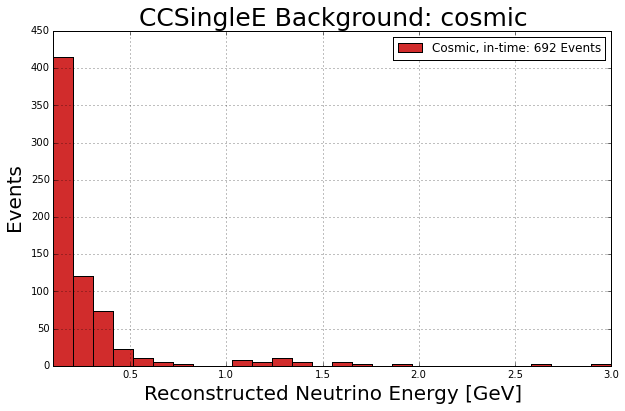

In [60]:
plot_onehist('cosmic',gen_histos(defaultcut))

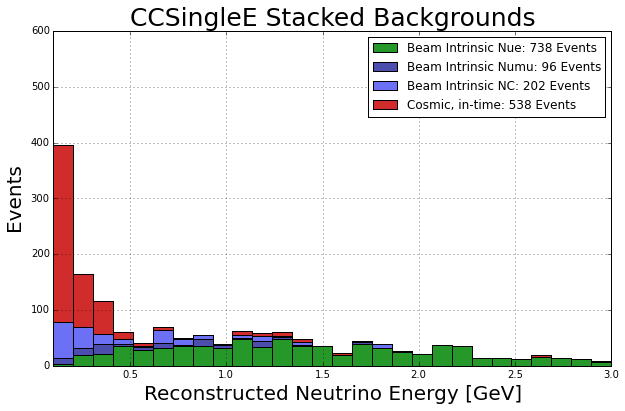

In [61]:
myhistos = gen_histos(fidvolcut+' and _longestTrackLen < 100')
plot_fullstack(myhistos)
#print compute_significance(myhistos)

In [62]:
def compute_significance(myhistos):
    numerator, denominator = 0., 0.
    for key, (hist, bins) in myhistos.iteritems():
        if key == 'nue': numerator += sum(hist)
        denominator += sum(hist)
    return numerator/np.sqrt(denominator)

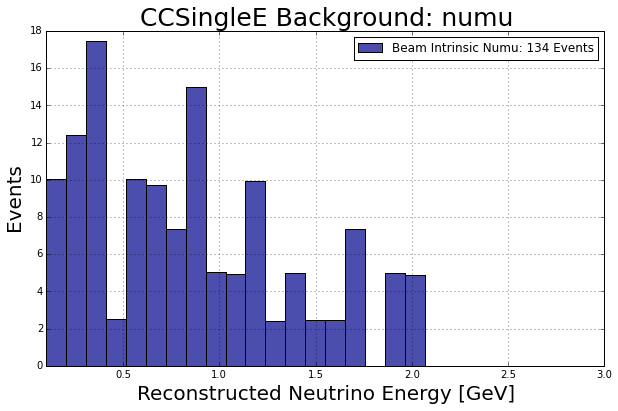

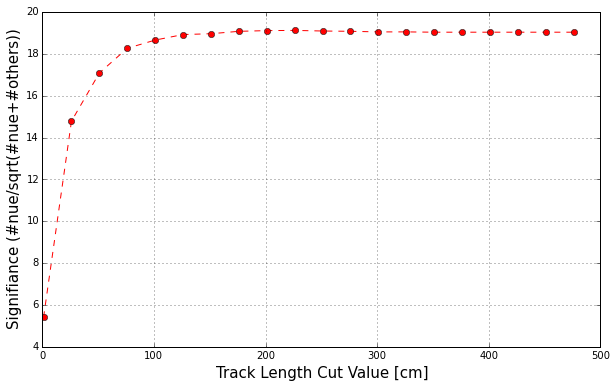

In [63]:
plot_onehist('numu',gen_histos(fidvolcut))
x, y = [], []
for longestlen in xrange(1,500,25):
    x.append(longestlen)
    y.append(compute_significance(gen_histos(fidvolcut + ' and _longestTrackLen < %f'%longestlen)))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(x,y,'ro--')
plt.xlabel('Track Length Cut Value [cm]',fontsize=15)
plt.ylabel('Signifiance (#nue/sqrt(#nue+#others))',fontsize=15)

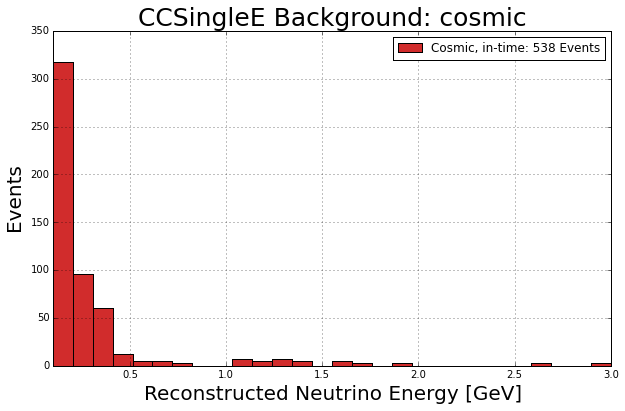

In [64]:
#myhistos = gen_histos('_is_fiducial==True and _longestTrackLen < 100')
myhistos = gen_histos(fidvolcut+ ' and _longestTrackLen < 100')
plot_onehist('cosmic',myhistos)

594


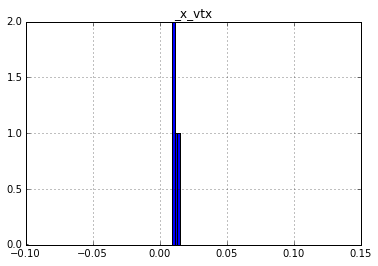

In [65]:
#dfs['cosmic'].hist('_x_vtx',bins=np.linspace(-10,266,250))
#dfs['cosmic'].hist('_x_vtx',bins=np.linspace(-10,266,250))
dfs['cosmic'].hist('_x_vtx',bins=np.linspace(-0.1,0.1,100))
print len(dfs['cosmic'])

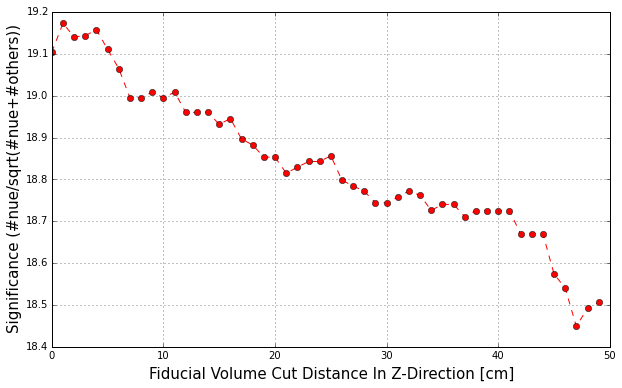

In [66]:
#Optimize y-fiducial volume cut
x, y = [], []
for cut_dist in xrange(0,50,1):
    fidvolcut = '_x_vtx > 0 and _x_vtx < 256.35 and _y_vtx > -116.5 and _y_vtx < 116.5 and _z_vtx > (0+%s) and _z_vtx < (1036.8-%s)'%(str(cut_dist),str(cut_dist))
    x.append(cut_dist)
    y.append(compute_significance(gen_histos(fidvolcut)))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(x,y,'ro--')
plt.xlabel('Fiducial Volume Cut Distance In Z-Direction [cm]',fontsize=15)
plt.ylabel('Significance (#nue/sqrt(#nue+#others))',fontsize=15)